# Prepare Vertices data for Rectangles

## Data
All data is in the **data** directory with 1 directory per user. 
### Directory Structure
For each sample, there is:
- An image like: images/rectangle/rectangle.aly.0001.png
- A file with the vertices coordinates, like: vertices/rectangle/rectangle.aly.0001.csv  

Where:
- The vertices file has 1 line per vertex

#### Vertex
Each Vertex has:
- a x coordinate between 0 and 1
- a y coordinate between 0 and 1  

Where
- (0,0) is the top left corner of the image
- (1,1) is the bottom right corner of the image


### Separate Train, Validation and Test sets
Each user will have all their images in 1 of the 3 sets. 


---
## ETL - Processing
For each of the Train, Validation and Test set:
- Load the image files
  - 70px x 70px gray (black on white) png files
- Normalize image:
  - All gray pixel are represented as a value between 0 and 1.
  - Black on white images are transforme to white on black.
- Prepare the labels based on the data in user/vertices csv files   
- Load **Train**, **Validation** and **Test** data into pickles for Estimation

In [1]:
import imageio
import numpy as np
import os
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline

# Our Module
from hds_module.utils import get_dir_paths, save_to_pickle
from hds_module.shape_utils import is_correct_shape_to_process, load_images_for_shape

seed1 = 125
np.random.seed(seed1)

verbose=False  # Set to True to get more output

## Specific parameters for that shape
Regarding anchor_x and anchor_y, see the Readme [here](https://github.com/frobertpixto/hand-drawn-shapes-dataset/blob/main/processing/find_vertices/README.md).

In [2]:
shape = "rectangle"
nb_vertices = 4

anchor_x = 0.2
anchor_y = 1.0

In [3]:
# We will store these params in the pickle with the data
params={"shape": shape, "nb_vertices": nb_vertices, "anchor_x": anchor_x, "anchor_y": anchor_y}

In [4]:
from platform import python_version
print(f'python: {python_version()}')

python: 3.11.12


In [5]:
BASEDIR = ".."

DATA_DIR       = os.path.join(BASEDIR, "..", "..", "data")

PICKLE_DIR     = os.path.join(BASEDIR, "pickles")
TRAIN_DATAFILE = os.path.join(PICKLE_DIR, f'train_{shape}.pickle')
VAL_DATAFILE   = os.path.join(PICKLE_DIR, f'val_{shape}.pickle')
TEST_DATAFILE  = os.path.join(PICKLE_DIR, f'test_{shape}.pickle')

In [6]:
# Define the Users for the Validation set and the Test set
# The Rest will go in the Training set
#
# The following definitions are arbitrary, but this is balanced and works well.
validation_users = ['drt', 'il1', 'lt1', 'lts', 'u01', 'u04', 'u04', 'u05', 'u08', 'u09', 'u10', 'u12', 'u17']
test_users = ['u18', 'u19']

In [7]:
# Get directory and file paths of Shape data with vertices
data_paths = get_dir_paths(DATA_DIR)
print(f"Dataset contains 1 directory per user:")
data_paths

Dataset contains 1 directory per user:


['../../../data/user.aly',
 '../../../data/user.crt',
 '../../../data/user.drt',
 '../../../data/user.elu',
 '../../../data/user.frt',
 '../../../data/user.if1',
 '../../../data/user.if2',
 '../../../data/user.if3',
 '../../../data/user.if5',
 '../../../data/user.if8',
 '../../../data/user.il1',
 '../../../data/user.ilb',
 '../../../data/user.im1',
 '../../../data/user.lrt',
 '../../../data/user.lt1',
 '../../../data/user.lts',
 '../../../data/user.mrt',
 '../../../data/user.nae',
 '../../../data/user.nld',
 '../../../data/user.u01',
 '../../../data/user.u02',
 '../../../data/user.u03',
 '../../../data/user.u04',
 '../../../data/user.u05',
 '../../../data/user.u06',
 '../../../data/user.u07',
 '../../../data/user.u08',
 '../../../data/user.u09',
 '../../../data/user.u10',
 '../../../data/user.u11',
 '../../../data/user.u12',
 '../../../data/user.u13',
 '../../../data/user.u14',
 '../../../data/user.u17',
 '../../../data/user.u18',
 '../../../data/user.u19',
 '../../../data/user.vly']

In [8]:
# Set image properties
image_size  = 70     # Pixel width and height
pixel_depth = 255.0  # Number of levels per pixel

In [9]:
# Create Pickle directory
Path(PICKLE_DIR).mkdir(parents=True, exist_ok=True)

# Functions

In [10]:
def load_images_for_user(user_root, pixel_depth,
                         user_images, user_images_labels,
                         user_images_paths, verbose=False):
    """
    Load all images and vertices for a specific user and shape
    """      
    images_dir = os.path.join(user_root, "images")

    if verbose:
        print("root for load_images_for_user: ", images_dir)

    shape_dirs = get_dir_paths(images_dir)
    for dir in shape_dirs:
        if is_correct_shape_to_process(dir, shape):
            load_images_for_shape(dir, pixel_depth, user_images, user_images_labels, user_images_paths, \
                                  vertice_count=nb_vertices, x_pos=anchor_x, y_pos=anchor_y, verbose=verbose)

In [11]:
def plot_sample(X, y, axs):
    axs.imshow(X.reshape(image_size, image_size), cmap="gray") # Put the Image
    y = y.ravel()
    axs.scatter(image_size * y[0::2], image_size * y[1::2], c='orange') # Add the labels as orange dots

In [12]:
# This function shows images with their real vertices
# Presentation is rows of 10 images
def display_images_with_vertices(X, Y):

    fig = plt.figure(figsize=(13, 9))
    fig.subplots_adjust(hspace=0.2,wspace=0.2,
                        left=0, right=1, bottom=0, top=1.5)

    nb_pictures = len(X)
    for i_pic in range(nb_pictures):
        x = X[i_pic]
        y = Y[i_pic]
        
        nb_per_row = 10
        nb_of_row  = (nb_pictures - 1) // nb_per_row + 1

        ax  = fig.add_subplot(nb_of_row, nb_per_row, i_pic + 1, xticks=[], yticks=[])
        plot_sample(x, y, ax)
    plt.show()

# Training data

In [13]:
train_user_images = []
train_user_images_labels = []
train_user_images_paths = {}

for user_dir in data_paths:
    user_id = user_dir[-3:]  # User unique id is the last 3 letters
    if user_id not in validation_users and user_id not in test_users:
        load_images_for_user(user_dir, pixel_depth, train_user_images, train_user_images_labels, \
                             train_user_images_paths, verbose=verbose)

train_data   = np.array(train_user_images)
train_labels = np.array(train_user_images_labels)

print('train_data shape: ', train_data.shape)
print('train_labels shape: ', train_labels.shape)

if verbose:
    # Show distribution of the x,y for all vertices 
    unique, counts = np.unique(train_labels, return_counts=True)
    print("train label dist.: ", dict(zip(unique, counts)))

# Save TRAIN datasets to single pickle file
save_to_pickle(
    TRAIN_DATAFILE,
    {
        'train_data': train_data,
        'train_labels': train_labels,
        'params': params
    }
)
print('Train Set Pickle saved in: ', TRAIN_DATAFILE)

train_data shape:  (5386, 70, 70)
train_labels shape:  (5386, 8)
Train Set Pickle saved in:  ../pickles/train_rectangle.pickle


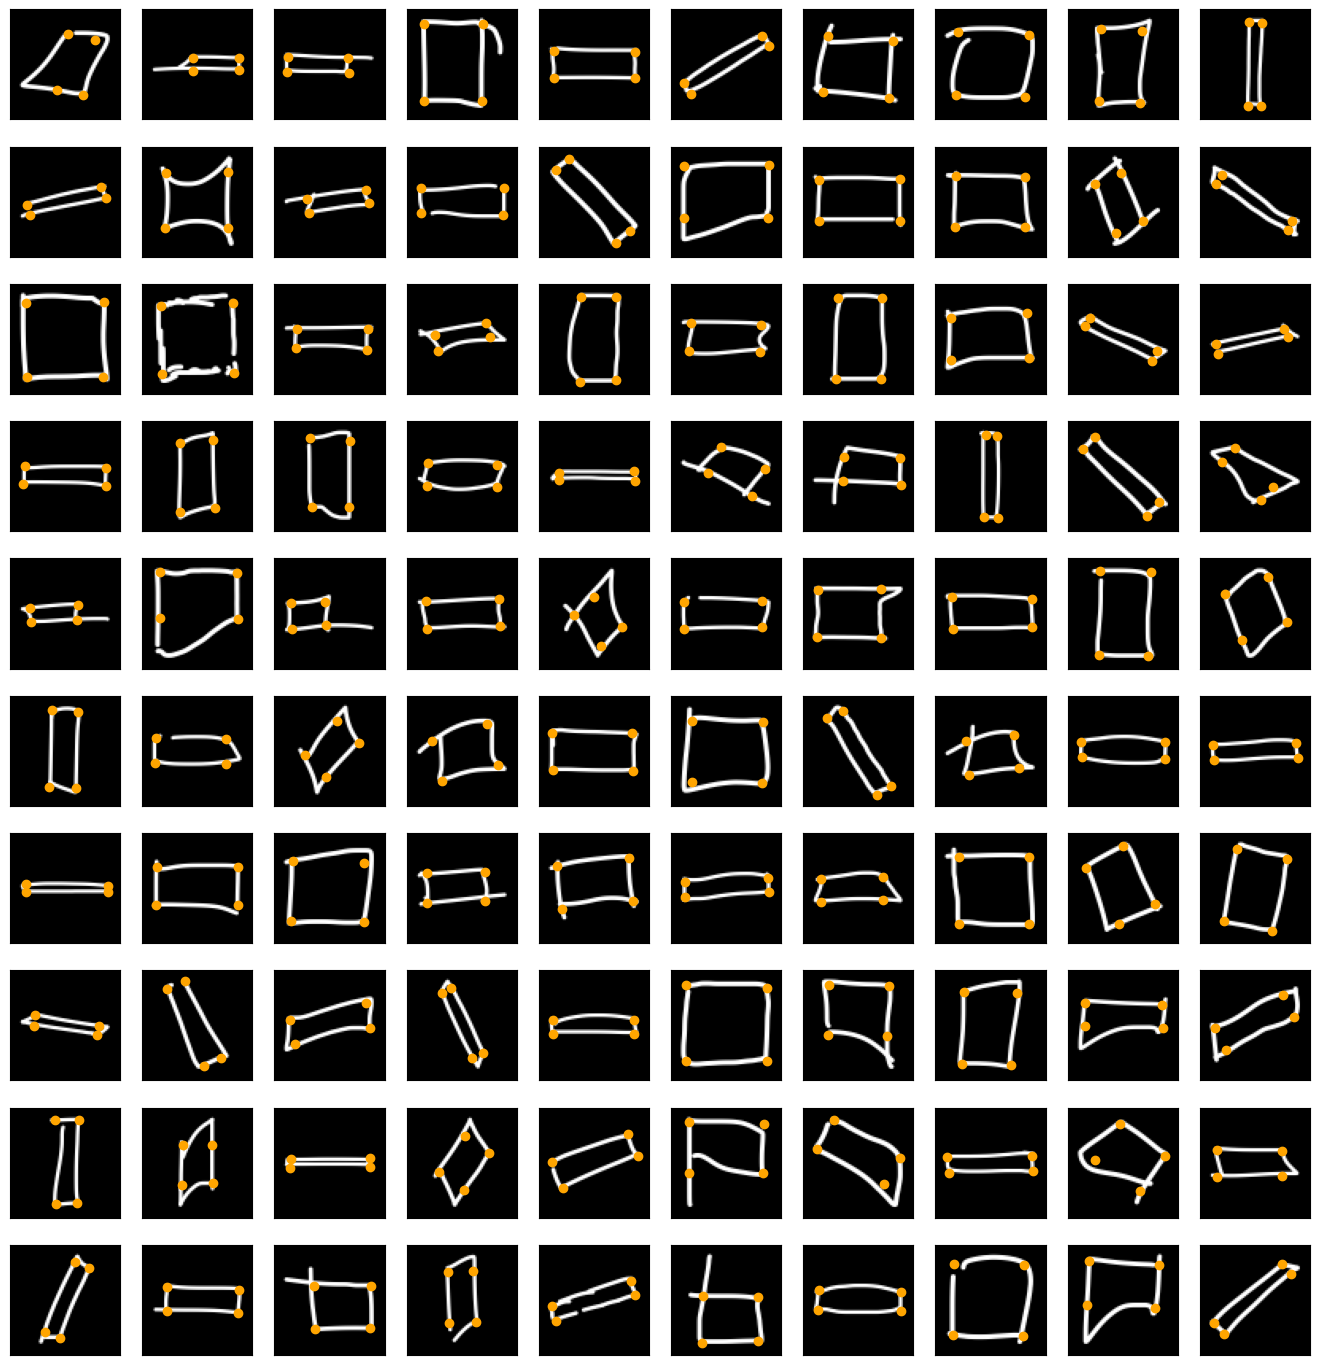

In [14]:
# Show random images from the Train Set + superimposed vertices
indexes = np.arange(len(train_labels))
np.random.shuffle(indexes)
first_random_indexes = indexes[:100]

display_images_with_vertices(train_data[first_random_indexes], train_labels[first_random_indexes])

In [15]:
del train_data
del train_labels

# Validation data

In [16]:
val_user_images = []
val_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:]  # User unique id is the last 3 letters
    if user_id in validation_users:
        load_images_for_user(user_dir, pixel_depth, val_user_images, val_user_images_label, \
                             train_user_images_paths, verbose=verbose)

val_data = np.array(val_user_images)
val_labels = np.array(val_user_images_label)

print('val_data shape: ', val_data.shape)
print('val_labels shape: ', val_labels.shape)

if verbose:
    # Show distribution of the x,y for all vertices
    unique, counts = np.unique(val_labels, return_counts=True)
    print("val label dist.: ", dict(zip(unique, counts)))

# Save VALIDATION datasets to single pickle file
save_to_pickle(
    VAL_DATAFILE,
    {
        'val_data': val_data,
        'val_labels': val_labels,
        'params': params
    }
)
print('Validation Set Pickle saved in: ', VAL_DATAFILE)

val_data shape:  (1391, 70, 70)
val_labels shape:  (1391, 8)
Validation Set Pickle saved in:  ../pickles/val_rectangle.pickle


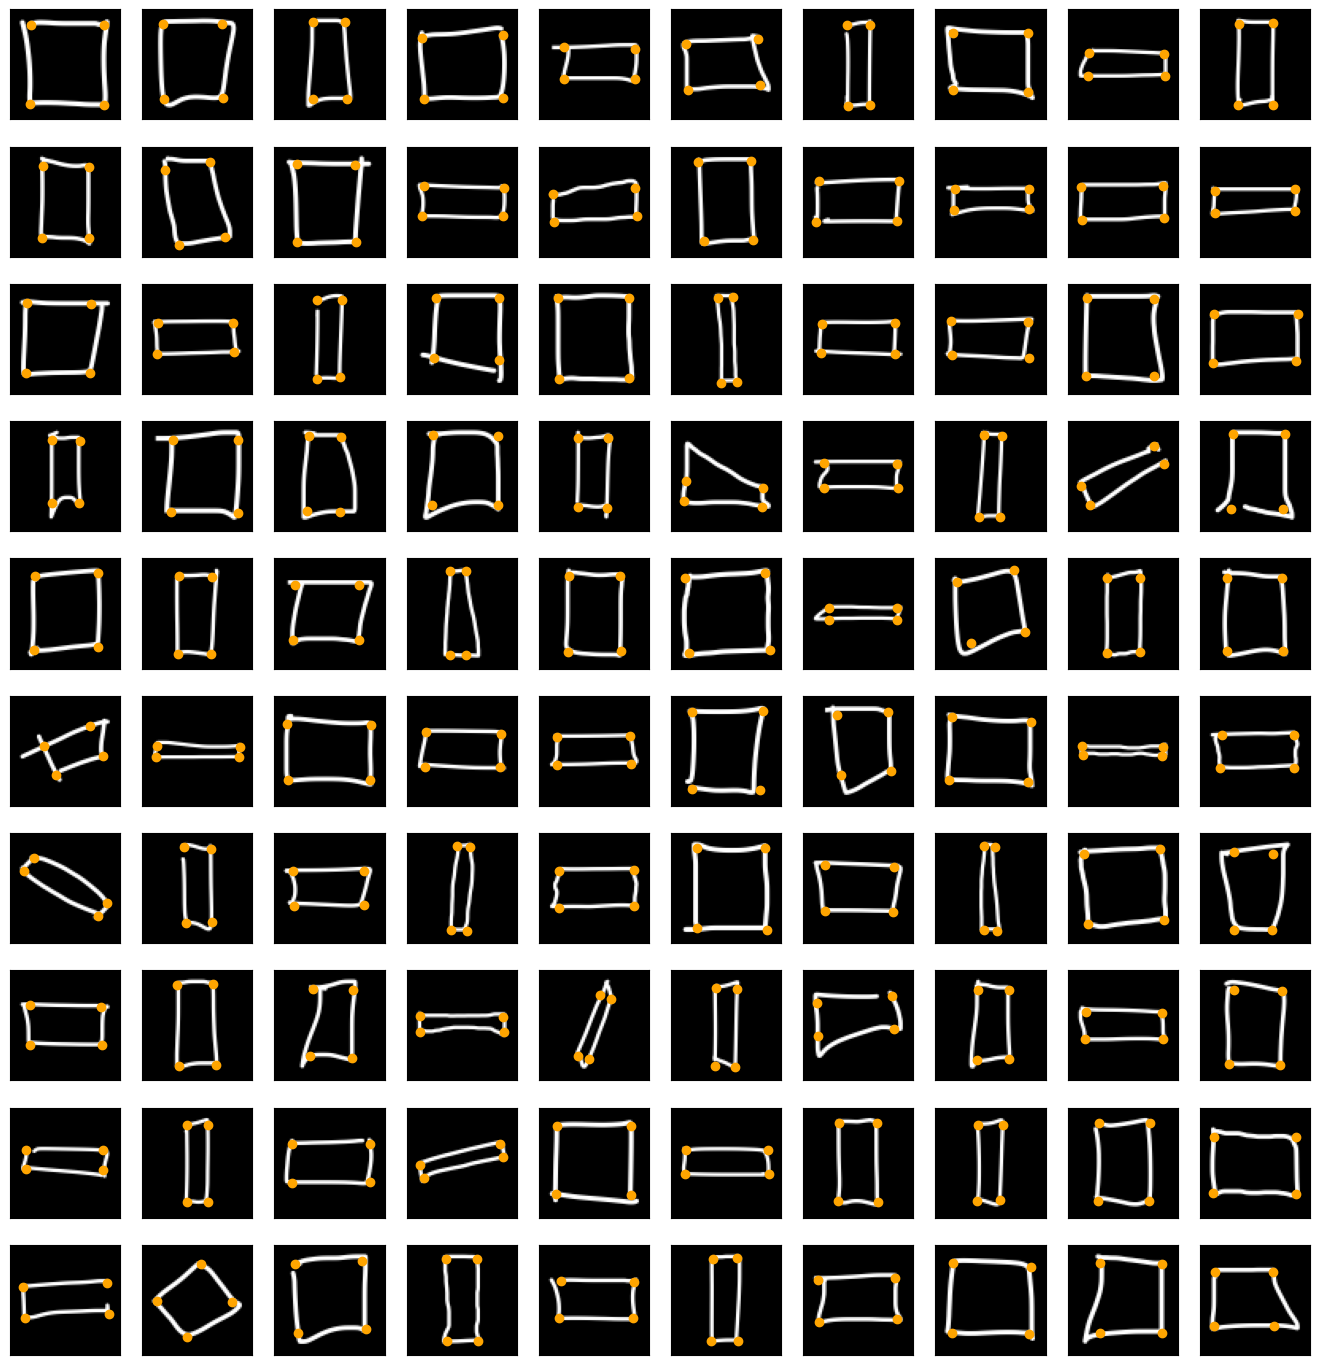

In [17]:
# Show random images from the Validation Set + superimposed vertices
indexes = np.arange(len(val_labels))
np.random.shuffle(indexes)
first_random_indexes = indexes[:100]

display_images_with_vertices(val_data[first_random_indexes],val_labels[first_random_indexes])

In [18]:
del val_data
del val_labels

# Test data

In [19]:
test_user_images = []
test_user_images_label = []

for user_dir in data_paths:
    user_id = user_dir[-3:]  # User unique id is the last 3 letters
    if user_id in test_users:
        load_images_for_user(user_dir, pixel_depth, test_user_images, test_user_images_label, \
                             train_user_images_paths, verbose=verbose)

test_data   = np.array(test_user_images)
test_labels = np.array(test_user_images_label)

print('test_data shape: ', test_data.shape)
print('test_labels shape: ', test_labels.shape)

if verbose:
    # Show distribution of the x,y for all vertices 
    unique, counts = np.unique(test_labels, return_counts=True)
    print("test label dist.: ", dict(zip(unique, counts)))

# Save TEST datasets to single pickle file
save_to_pickle(
    TEST_DATAFILE,
    {
        'test_data': test_data,
        'test_labels': test_labels,
        'params': params
    }
)
print('Test Set Pickle saved in: ', TEST_DATAFILE)

test_data shape:  (179, 70, 70)
test_labels shape:  (179, 8)
Test Set Pickle saved in:  ../pickles/test_rectangle.pickle


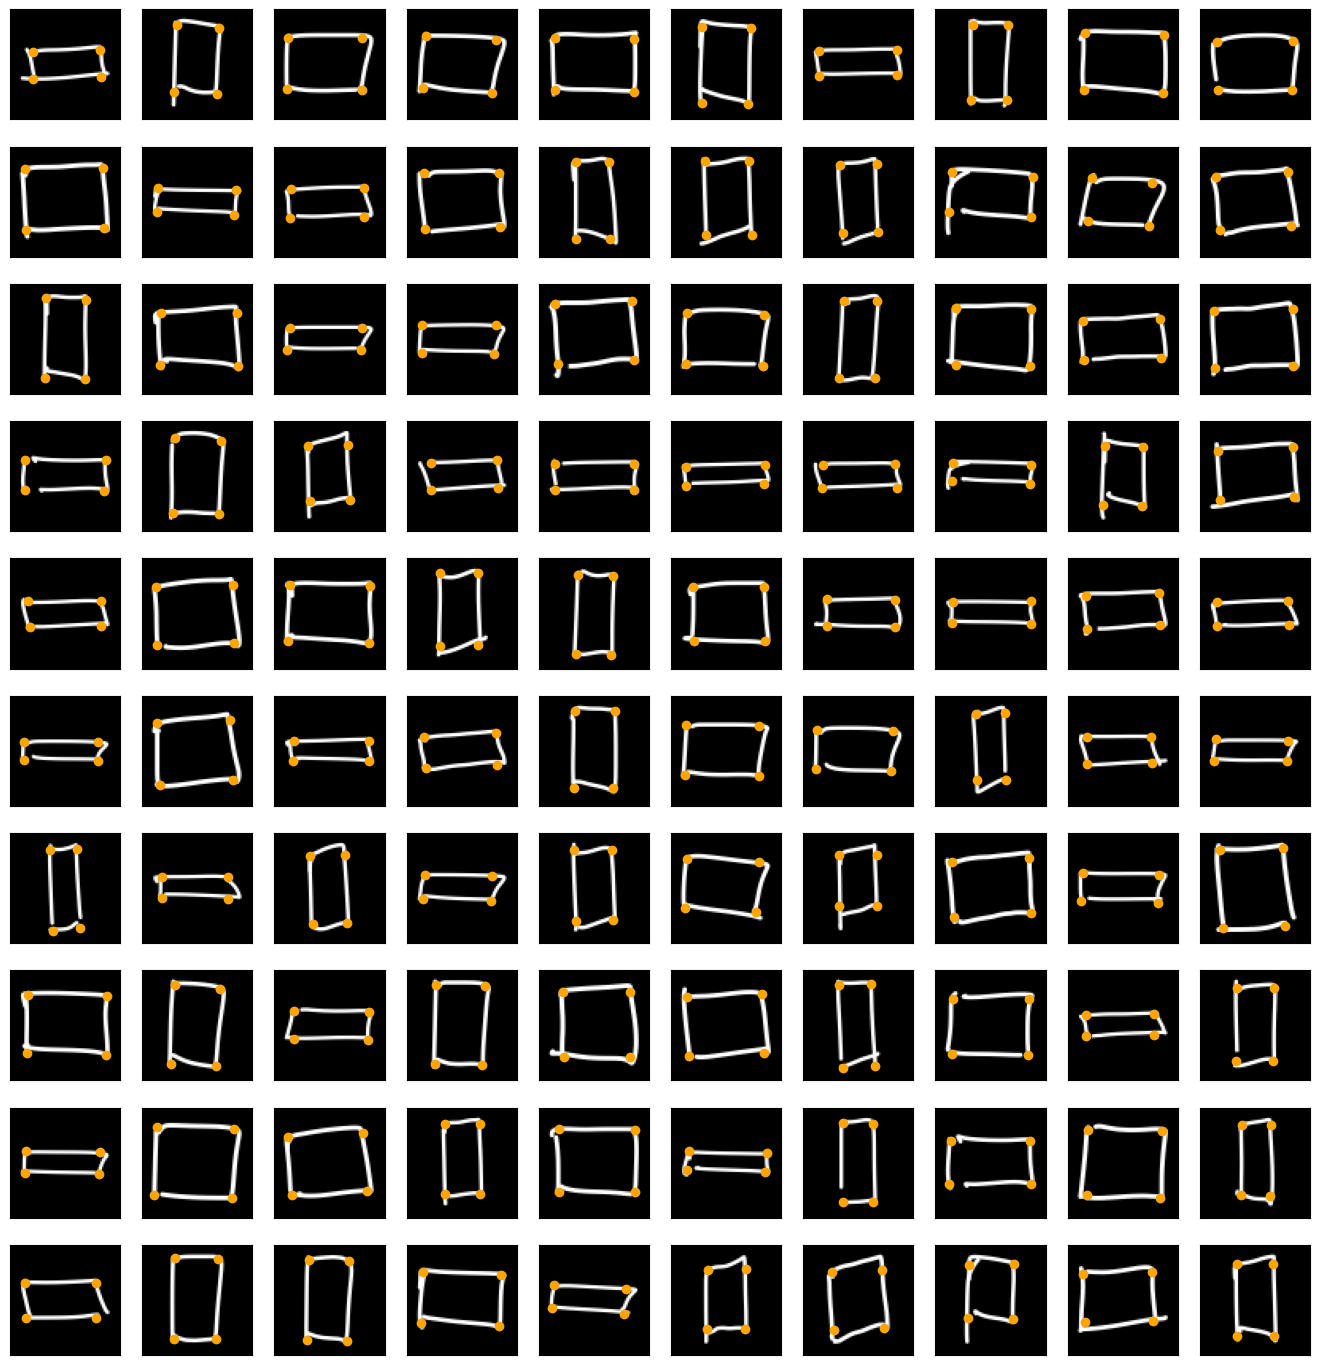

In [20]:
# Show random images from the Test Set + superimposed vertices
indexes = np.arange(len(test_labels))
np.random.shuffle(indexes)
first_random_indexes = indexes[:100]

display_images_with_vertices(test_data[first_random_indexes], test_labels[first_random_indexes])

## ETL Completed